In [ ]:
!pip install fake_useragent
from bs4 import BeautifulSoup
from bs4.element import Tag
import requests
import time
from fake_useragent import UserAgent
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
df = pd.read_csv('df-2.csv')

Будем использовать для машинного обучения обычную линейную регрессию, Lasso-регрессия, Ridge-регрессию, а также деревья: решающее дерево и случайный лес. В качестве метрик будет использовать MSE, MAE, R2-score

Делим выборку на train и test, размер тестовой выборки - 30%

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Цена'), df['Цена'], test_size=0.3, random_state=42)

1 этап - Линейна регрессия

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
#обучение модели

LinearRegression()

In [ ]:
print(f'MSE train {mean_squared_error(y_train, model.predict(X_train))}')
print(f'MSE test {mean_squared_error(y_test, model.predict(X_test))}')
print(f'MAE train {mean_absolute_error(y_train, model.predict(X_train))}')
print(f'MAE test {mean_absolute_error(y_test, model.predict(X_test))}')
print(f'R2 train: {r2_score(y_train, model.predict(X_train))}')
print(f'R2 test: {r2_score(y_test, model.predict(X_test))}')

MSE train 1481996.5763075948
MSE test 2369760.2150750877
MAE train 831.3842084497348
MAE test 973.1283435611415
R2 train: 0.3027405019292555
R2 test: 0.18165862473868333


Модель получилась, откровенно говоря, не очень. Значение r2 метрики на тесте меньше 0.2, большое ухудшение обоих ошибок относительно тренировочной выборки (а также немаленькое значение среднего веса) говорит о том, что модель переобучена. Исправим это!

In [ ]:
model.coef_.mean()

271.1665900196032

2 этап - Lasso-regression
воспользуемся Lasso регуляризацией, выбирем некоторые альфа и найдем лучшую модель

In [ ]:
alphas = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7]
best_alpha = -10
best_mse=10**15
for alpha_ in alphas:
  clf = linear_model.Lasso(alpha=alpha_)
  clf.fit(X_train, y_train)
  mse = mean_squared_error(y_test, clf.predict(X_test))
  if mse < best_mse:
    best_mse = mse
    best_alpha = alpha_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.134e+08, tolerance: 1.719e+05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.048e+08, tolerance: 1.719e+05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.225e+08, tolerance: 1.719e

In [ ]:
clf = linear_model.Lasso(alpha=best_alpha)
clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.236e+08, tolerance: 1.719e+05
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.1)

In [ ]:
print(f'MSE train {mean_squared_error(y_train, clf.predict(X_train))}')
print(f'MSE test {mean_squared_error(y_test, clf.predict(X_test))}')
print(f'MAE train {mean_absolute_error(y_train, clf.predict(X_train))}')
print(f'MAE test {mean_absolute_error(y_test, clf.predict(X_test))}')
print(f'R2 train: {r2_score(y_train, clf.predict(X_train))}')
print(f'R2 test: {r2_score(y_test, clf.predict(X_test))}')
print(f'Среднее значение весов равно: {clf.coef_.mean()}')

MSE train 1531838.011264365
MSE test 2348729.7462018416
MAE train 848.0558102698966
MAE test 961.9577836880013
R2 train: 0.27929077574455063
R2 test: 0.18892100627021613
Среднее значение весов равно: -65.53968871282933


Результат: модель получилась лучше, чем обычная линейная регрессия: значение r2 на тесте стало слегка побольше, МАЕ на тесте также уменьшилась, но не сильно. Однако значению коэффициентов это помогло: среднее значение весов упало почти в 6 раз, следовательно, наша модель теперь чуть более интерпретируема. Для чистоты эксперимента применим также L2 регуляризацию

3 этап - Ridge-regression
Действуем также, выбираем лучшую модель перебором разных альф

In [ ]:
alphas = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1, 2]
best_alpha_ridge = -10
best_mse_ridge = 10**10
for alpha_ in alphas:
  clf_ridge = Ridge(alpha=alpha_)
  clf_ridge.fit(X_train, y_train)
  mse = mean_squared_error(y_test, clf_ridge.predict(X_test))
  if mse < best_mse_ridge:
    best_mse_ridge = mse
    best_alpha_ridge = alpha_

In [ ]:
clf_ridge = Ridge(alpha=best_alpha_ridge)
clf_ridge.fit(X_train, y_train)

Ridge(alpha=0.01)

In [ ]:
print(f'MSE train {mean_squared_error(y_train, clf_ridge.predict(X_train))}')
print(f'MSE test {mean_squared_error(y_test, clf_ridge.predict(X_test))}')
print(f'MAE train {mean_absolute_error(y_train, clf_ridge.predict(X_train))}')
print(f'MAE test {mean_absolute_error(y_test, clf_ridge.predict(X_test))}')
print(f'R2 train: {r2_score(y_train, clf_ridge.predict(X_train))}')
print(f'R2 test: {r2_score(y_test, clf_ridge.predict(X_test))}')
print(f'Среднее значение весов равно: {clf_ridge.coef_.mean()}')

MSE train 1522327.943972428
MSE test 2350737.833725368
MAE train 845.0419674798385
MAE test 962.6676115341908
R2 train: 0.2837651347630552
R2 test: 0.1882275601168063
Среднее значение весов равно: -55.63057590633922


Линейная модель обученная Ridge регрессией сопоставима с Лассо регрессией. Значение ошибок примерно такое же, показатели R2 отличаются несильно.

Итог: регуляризация действительно улучшила нашу модель, однако это улучшение относительно, ибо если смотреть глобально - то в среднем наша модель ошибается при предсказании на 962 рублей (МАЕ на тесте) и лишь 19% дисперсий объяснено моделью. Стоит попробовать другие методы машинного обучения для того, чтобы как-то справиться с этой проблемой.

**4 этап** - решающие деревья

Строим стандартное решающее дерево, параметры подбираю с помощью `GridSearchCV`

In [ ]:
dt = DecisionTreeRegressor(random_state=69)
parametrs_dt = {'max_depth': [1, 2, 3, 5, 7, 10, 12, 15], 'min_samples_split': [2, 3, 4, 5, 6], 'min_samples_leaf': [1, 3, 5, 7, 10, 15, 20, 25]}

In [ ]:
grid_dt = GridSearchCV(estimator = dt, param_grid = parametrs_dt, scoring = 'r2', n_jobs=-1, cv=5)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

{'max_depth': 2, 'min_samples_leaf': 25, 'min_samples_split': 2}


Обучаем решающее дерево с лучшими параметрами, найденным в предыдущих строчках кода

In [ ]:
dt_best_model = DecisionTreeRegressor(max_depth = 2, min_samples_leaf = 25, min_samples_split = 2, random_state=69)
dt_best_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, min_samples_leaf=25, random_state=69)

In [ ]:
print(f'MSE train {mean_squared_error(y_train, dt_best_model.predict(X_train))}')
print(f'MSE test {mean_squared_error(y_test, dt_best_model.predict(X_test))}')
print(f'MAE train {mean_absolute_error(y_train, dt_best_model.predict(X_train))}')
print(f'MAE test {mean_absolute_error(y_test, dt_best_model.predict(X_test))}')
print(f'R2 train: {r2_score(y_train, dt_best_model.predict(X_train))}')
print(f'R2 test: {r2_score(y_test, dt_best_model.predict(X_test))}')

MSE train 1741883.707849038
MSE test 2646244.48359389
MAE train 931.2989467501877
MAE test 1019.9697395903196
R2 train: 0.1804670946956738
R2 test: 0.08618123630990238


Относительно линейной модели с регуляризацией решающее дерево сильно хуже предсказывает цену. Ошибки выросли, R2 упала, поэтому останавливаться не будем - попробуем случайный лес!

**5 этап** - случайный лес

Как и с решающим деревом, подбираем параметры тем же методом

"А теперь построим леса!" - © Ана Тони, председатель Гринпис с 2011 года

In [ ]:
rf = RandomForestRegressor(random_state=69)
parametrs_rf = {'max_depth': [1, 2, 3, 5, 7, 10], 'min_samples_split': [2, 3, 4, 5, 6],
                'min_samples_leaf': [1, 2, 3, 5, 7, 10, 15, 20]}

In [ ]:
grid_rf = GridSearchCV(estimator = rf, param_grid = parametrs_rf, scoring = 'r2', n_jobs=-1, cv=5)
grid_rf.fit(X_train, y_train)
print(grid_rf.best_params_)

{'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}


Обучаем лучший случайный лес с параметрами `'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2`

In [ ]:
rf_best_model = RandomForestRegressor(max_depth = 10, min_samples_leaf = 10, min_samples_split =2, random_state=69)
rf_best_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=10, random_state=69)

In [ ]:
print(f'MSE train {mean_squared_error(y_train, rf_best_model.predict(X_train))}')
print(f'MSE test {mean_squared_error(y_test, rf_best_model.predict(X_test))}')
print(f'MAE train {mean_absolute_error(y_train, rf_best_model.predict(X_train))}')
print(f'MAE test {mean_absolute_error(y_test, rf_best_model.predict(X_test))}')
print(f'R2 train: {r2_score(y_train, rf_best_model.predict(X_train))}')
print(f'R2 test: {r2_score(y_test, rf_best_model.predict(X_test))}')

MSE train 1166749.385406574
MSE test 2415921.6246609204
MAE train 726.0091563243975
MAE test 974.3871569745379
R2 train: 0.4510600740591142
R2 test: 0.16571785943923967


Изучим важность признаков: найдем 10 наиболее важных в модели, показавшей себя лучше всего - Lasso регрессия (выбор пал на нее, т.к. она лучше борется с выбросами)

In [ ]:
X = dict(zip(df.columns, clf.coef_))
X_vis = pd.DataFrame(sorted(X.items(), key = lambda y: abs(y[1]), reverse = True)[:10])

Text(0.5, 1.0, '10 наиболее важных признаков в Lasso_regression')

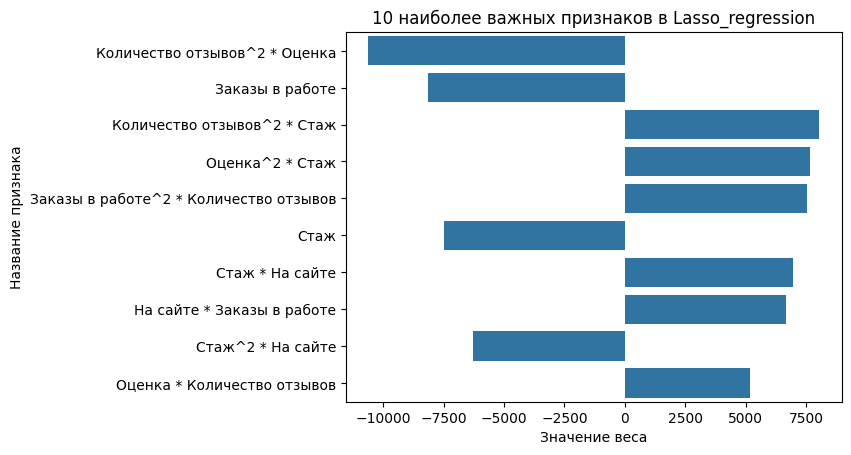

In [ ]:
sns.barplot(X_vis, x=1, y =0)
plt.xlabel('Значение веса')
plt.ylabel('Название признака')
plt.title('10 наиболее важных признаков в Lasso_regression')

Интересно, что в топ-5 всего один признак, не являющийся полиномом. Интепретировать такие коэффициенты довольно сложно, однак можно сказать следующее: важно значение заказов в работе у репетитора, причем, зависимость отрицательная. Очень неинтуитивная вещь - ведь с ростом количества заказов в работе, наоборот, должна расти цена. Возможно, много заказов берут люди, у которых цена ниже и их в выборке больше, поэтому получается такое значение веса. Также большой отрицательный вес у стажа. Здесь частично подтверждается гипотеза, что чем выше стаж у тьютора, тем, скорее всего, это человек с большим возрастом, который, возможно, не так много работал репетитором (а пол жизни проработал в школе) и еще не особенно понимает конъюктуру рынка. В полиномах особенно были важны такие комбинации признаков, как: `Стаж, Количество отзывов, Заказы в работе`.

**6 этап: итог**

Обучив 5 моделей, на выходе получаем, что среди них лучший результат показывает линейная регрессия с лассо регуляризацией: наблюдается улучшенеие всех метрик и на тесте, и на трейне. Однако, к большому сожалению, ни одна из построенных моделей не оказалась хороша в абсолютном выражении: в среднем, наша лучшая модель ошибается на 962 рублей при предсказании цены репетитора, причем, лишь 19% в общей доли изменений таргета наша модель в силах объяснить. Возможно, проблема в данных, так как для многих репетиторов, например, не было ни отзывов, ни оценки, что могло сильно сказаться на качестве предсказаний.